# Computer Project
initialsating code and formatting data pre-processed from **EF5042_homework_data_20220520.xls** 

In [104]:
# Initialsation

import pandas as pd 
import numpy as np
import scipy as sp
import sklearn.linear_model as skl_lm
import scipy.stats as sp_stats
import matplotlib.pyplot as plt

# import data files

# returs of the companies
ret = pd.read_csv("HW1 Ret.csv")
# CRSP market weighted returns
vw_ret = pd.read_csv("HW1 VWRet.csv")

# formating data
ret.set_index("date", inplace=True)
ret.index = pd.to_datetime(ret.index,format ="%Y%m%d")
vw_ret.set_index("date", inplace=True)
vw_ret.index = pd.to_datetime(ret.index,format ="%Y%m%d")

# generate "fit"
vw_ret = pd.DataFrame(vw_ret.iloc[:,0])
vw_ret.columns = ["VW MARKET"]

data = ret.join(vw_ret)
data["ONES"] = 1

# Proper Row & Column Order
cols = ["Mean","Std","Beta","SE","t Stat","R2","CAPM Ret","Obs"]
rows = ["WALMART","MERCK","MCDONALDS",'COKE','JOHNSON','PFIZER','INTEL','IBM','MICROSOFT','3M','NETFLIX','APPLE','AMAZON','EXXON','FACEBOOK','SALESFORCE','DISNEY','BOEING','ASML','NVIDIA']


#### 1a\) fitting OLS Model 
fitting linear model in the form of 

$R_{i} = \alpha_{i} + \beta_{i} R_{m,t} + \varepsilon_{i,t}$ 

for all 20 stocks 

In [106]:
results = pd.DataFrame(columns=["Alpha","Beta","SE"], index = ret.columns)
reg = skl_lm.LinearRegression(fit_intercept=False, n_jobs=len(ret.columns))
rf = 0.03

for stock in ret.columns: 
    # Fitting Model 
    reg_data = data.loc[:,["ONES",stock,"VW MARKET"]].dropna()
    X = reg_data.loc[:,["ONES","VW MARKET"]] 
    Y = reg_data[stock]
    reg.fit(X,Y)
    
    results.loc[stock,["Alpha","Beta"]] = reg.coef_


    # Standard Error 
    Yhat = reg.predict(X)
    t = len(X)
    SSE = ((Y-Yhat)**2).sum()
    SMV = ((reg_data["VW MARKET"]-reg_data["VW MARKET"].mean())**2).sum()

    results.loc[stock,"SE"] = (SSE/((t-2)*SMV))**0.5
    
    # Observations
    results.loc[stock,"Obs"] = int(t)

    # R2 Score
    results.loc[stock,"R2"] = reg.score(X,Y)

    # CAPM Returns
    results.loc[stock,"CAPM Ret"] = rf + results.loc[stock,"Beta"]*(data["VW MARKET"].mean() - rf)

results.loc[rows,["Alpha","Beta"]]

,Alpha,Beta
WALMART,0.005703,0.373794
MERCK,0.004422,0.451271
MCDONALDS,0.007931,0.478201
COKE,0.00223,0.556451
JOHNSON,0.003272,0.596011
PFIZER,0.005487,0.66661
INTEL,0.002715,0.731177
IBM,-0.005502,0.901359
MICROSOFT,0.009805,0.918883
3M,-0.002044,0.95134


#### 1b,c\) plotting Monthly Return Against CRSP Market Weighted Returns & Charateristic Line


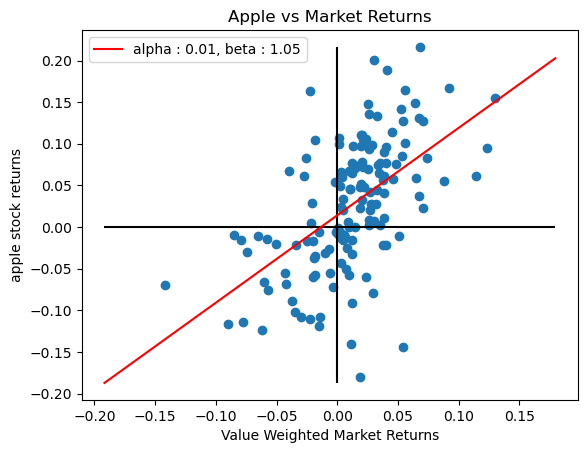

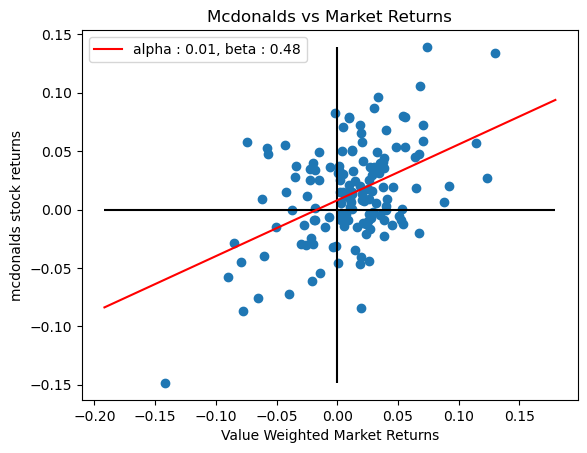

In [101]:
spread = 0.05
xlb = data["VW MARKET"].min()-spread
xub = data["VW MARKET"].max()+spread
X = np.linspace(xlb,xub,1000)
n = 1

for stock in ["APPLE","MCDONALDS"]:
    Y = results.loc[stock,"Alpha"] + results.loc[stock,"Beta"]*X

    plt.figure(n)
    plt.plot(X,Y, color ="r")
    plt.legend(["alpha : {}, beta : {}".format(round(results.loc[stock,"Alpha"],2),round(results.loc[stock,"Beta"],2))])
    plt.xlabel("Value Weighted Market Returns")
    plt.ylabel("{} stock returns".format(stock.lower()))
    plt.title("{} vs Market Returns".format(stock[0] + stock[1:].lower()))

    # axis
    plt.hlines(0,xlb,xub,colors="k")
    plt.vlines(0,min(Y.min(),data[stock].min()),max(Y.max(),data[stock].max()),colors="k")

    # scatter plot
    plt.scatter(data["VW MARKET"],data[stock])
    n+=1




#### 1d\) Anualised Mean & Standard Deviations 

In [112]:
results["Mean"] = data.drop("ONES",axis = 1).mean()*12
results["Std"] = data.drop("ONES",axis = 1).std()*(12**0.5)
market_mean = data["VW MARKET"].mean()*12
market_std = data["VW MARKET"].std()*(12**0.5)

print("Annualised Value Weighted Market Return, Mean : {}, Std : {}".format(round(market_mean,3),round(market_std,3)))
results.loc[rows,["Mean","Std"]]


Annualised Value Weighted Market Return, Mean : 0.139, Std : 0.142


,Mean,Std
WALMART,0.120492,0.166899
MERCK,0.115910,0.175605
MCDONALDS,0.161762,0.146600
COKE,0.104252,0.154317
JOHNSON,0.122263,0.148412
PFIZER,0.158673,0.198237
INTEL,0.134401,0.231320
IBM,0.059503,0.205010
MICROSOFT,0.245627,0.212661
3M,0.107959,0.182545


#### 1e\) Plotting Mean Returns Against Beta

Returns do seem to lie on a line, but it seems to differ from what is suggested by CAPM

Emperical Slope: 0.213, Market Return - Risk Free : 0.109
Emperical Intercept: 0.017, Risk Free: 0.03


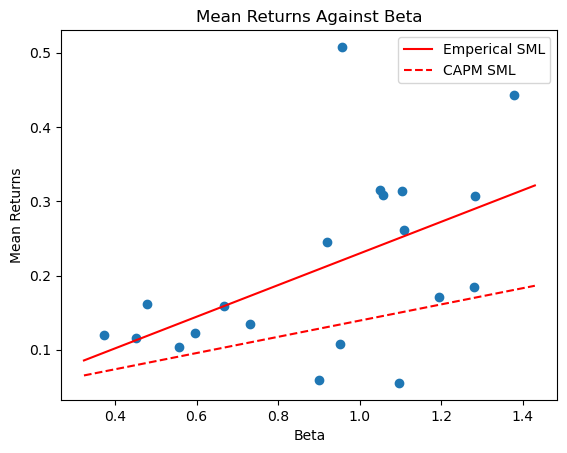

In [123]:
new_reg_data = pd.DataFrame(results["Beta"]).join(results["Mean"])
new_reg_data["ONES"] = 1

reg.fit(new_reg_data.loc[:,["ONES","Beta"]],new_reg_data["Mean"])


spread = 0.05
xlb = new_reg_data["Beta"].min()-spread
xub = new_reg_data["Beta"].max()+spread
X = np.linspace(xlb,xub,1000)


Y = reg.coef_[0] + reg.coef_[1]*X

plt.figure(n)
plt.plot(X,Y,"r")
plt.title("Mean Returns Against Beta")
plt.xlabel("Beta")
plt.ylabel("Mean Returns")


# scatter plot
plt.scatter(new_reg_data["Beta"],new_reg_data["Mean"])
n+=1

slope = reg.coef_[1]
rm = data["VW MARKET"].mean()*12
print("Emperical Slope: {}, Market Return - Risk Free : {}".format(round(slope,3), round(rm-rf,3)))
print("Emperical Intercept: {}, Risk Free: {}".format(round(reg.coef_[0],3), round(rf,3)))


Y2 = rf + (rm-rf)*X
plt.plot(X,Y2, "r--")
plt.legend(["Emperical SML", "CAPM SML"])


#### 1f,g,h\) Calculation of Standard Error & CAPM Returns

Values previously calculated in the OLS model fitting step

In [126]:
results["t Stat"] = results["Beta"]/results["SE"]

results.loc[rows,["SE","t Stat","CAPM Ret"]]


,SE,t Stat,CAPM Ret
WALMART,0.093566,3.994971,0.023124
MERCK,0.09668,4.667678,0.021699
MCDONALDS,0.076833,6.22389,0.021204
COKE,0.078391,7.09844,0.019764
JOHNSON,0.072104,8.265949,0.019036
PFIZER,0.103004,6.471721,0.017738
INTEL,0.12224,5.98151,0.016550
IBM,0.094723,9.515731,0.013420
MICROSOFT,0.099323,9.251462,0.013097
3M,0.07264,13.096651,0.012500


#### Results (Displayed as per Template)

In [127]:
results.loc[rows,cols]

,Mean,Std,Beta,SE,t stat,R2,CAPM Ret,Obs
WALMART,0.120492,0.166899,0.373794,0.093566,3.994971,0.101037,0.023124,144.0
MERCK,0.115910,0.175605,0.451271,0.09668,4.667678,0.133021,0.021699,144.0
MCDONALDS,0.161762,0.146600,0.478201,0.076833,6.22389,0.214327,0.021204,144.0
COKE,0.104252,0.154317,0.556451,0.078391,7.09844,0.261908,0.019764,144.0
JOHNSON,0.122263,0.148412,0.596011,0.072104,8.265949,0.324857,0.019036,144.0
PFIZER,0.158673,0.198237,0.66661,0.103004,6.471721,0.227771,0.017738,144.0
INTEL,0.134401,0.231320,0.731177,0.12224,5.98151,0.201253,0.016550,144.0
IBM,0.059503,0.205010,0.901359,0.094723,9.515731,0.389376,0.013420,144.0
MICROSOFT,0.245627,0.212661,0.918883,0.099323,9.251462,0.376070,0.013097,144.0
3M,0.107959,0.182545,0.95134,0.07264,13.096651,0.547082,0.012500,144.0
